## Nature's Cost Function: Simulating Physics by Minimizing the Action
Tim Strang, Isabella Caruso, and Sam Greydanus | 2023 | MIT License

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [ ]:
### These are some peripheral functions that streamline later calculations ###

def gaussian(x, mu, sig):
    norm = math.sqrt(2 * math.pi) * sig
    return np.exp(-((x - mu) * (x - mu)) / (2 * sig * sig)) / norm

def linfunc(low, hi, N):
  return np.linspace(low, hi, N)

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
def normalize(q):
    return q / q.norm()

In [2]:
### These are the functions that define the core physics and perform bulk calculations ###

# dx and dt are in expressed in atomic physics natural units
# The numbers are proportional to hbar/(m_e c) and hbar/(m_e c^2), respectively

# defining the potential landscape for a sim
def V(N, div, coeffs):
    lin = linfunc(-N/div, N/div, N)
    pot = 0*lin
    for i, coeff in enumerate(coeffs):
      pot = pot + coeff * lin ** i     
    return pot

# initializing relevant system parameters
def init(hprms, coeffs=[]):
    constants = ObjectView(dict(
                             hbar=1/hprms.scale, m=hprms.m, 
                             numdx=int(hprms.spatial_density*hprms.scale**1.5),
                             numdt=int(hprms.time_density*hprms.scale**1.5), xrange=int(hprms.xrange), 
                             trange=int(hprms.trange), mom=hprms.momentum
                            ))
    
    dx = constants.xrange / constants.numdx  # scalar
    dt = constants.trange / constants.numdt  # scalar
    alpha = constants.m * (dx ** 2 / (2 * constants.hbar * dt))  # scalar
    beta = dt / constants.hbar  # scalar
    steps = constants.numdt // constants.trange
    interval = 2000 * hprms.vid_length / constants.numdt
    
    x = np.linspace(0, constants.xrange, constants.numdx)
    t = np.linspace(0, constants.trange, constants.numdt)

    ST, SV, K = construct_operators(constants.numdx, hprms.div, coeffs, alpha, beta)

    r0 = gaussian(x, constants.xrange/2, .025*constants.xrange)[:,None] # r0: [N x 1]
    r0[0, 0] = r0[-1, 0] = 0
    q0 = np.concatenate((np.cos(constants.mom * x)[:,None] * r0,
                         np.sin(constants.mom * x)[:,None] * r0), axis=1)
    q = torch.view_as_complex(torch.tensor(q0))
    return ObjectView(dict(x=x, t=t, ST=ST, SV=SV, K=K, q=q, interval=interval, steps=steps, dx=dx))

# calculating action over linear paths; constructing K-matrix
def construct_operators(N, div, coeffs, alpha, beta):
    ST, SV = np.zeros((2, N, N)) # both are [N x N] matrices
    temp = np.arange(N)
    pot = V(N, div, coeffs)
    for l in range(N):
        ST[:, l] += temp
        ST[l, :] -= np.transpose(temp)
        SV[:, l] += pot
        SV[l, :] -= np.transpose(pot)
    ST *= alpha * ST
    SV *= beta
    ST = torch.tensor(ST) * 1
    SV = torch.tensor(SV) * 1
    K = (torch.complex(0*ST, ST) - torch.complex(0*SV, SV)).exp()
    return ST, SV, K

# evlolving initial wavefunc through time
def simulate(q, K, steps=500):
    q = normalize(q)
    qs = [q.clone()]
    for i in range(steps):
        q = normalize(q @ K)
        qs.append(q.clone())
    return torch.stack(qs)

In [ ]:
### These are our core visualization functions ###

# making a video of the 1D wavefunc evolving
def make_video(x, qs, title, dx, path, interval=60, **kwargs):
    plt.title(title, fontweight="bold")
    plt.ylabel('Sqrt of Probability Density')
    fig = plt.gcf() ; fig.set_dpi(100) ; fig.set_size_inches(5, 3)
    camera = Camera(fig)
    
    for i, q in enumerate(qs):
        plt.plot(x, q.abs().detach(), 'b', label='Sqrt probability density')
        plt.axvline(torch.sum(torch.from_numpy(x)*q.abs().detach()).item()/torch.sum(q.abs().detach()).item(),
                    ls='-', color='firebrick')
        camera.snap()
    anim = camera.animate(blit=True, interval=interval, **kwargs)
    anim.save(path)
    plt.close()
    
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML('<video width=400 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

# basic matplotlib setups
def make_static(lft, lftnm, rgt, rgtnm, path):
    fig = plt.figure(figsize=(6, 3), dpi=300)
    ax1 = fig.add_subplot(121)
    ax1.imshow(lft) ; ax1.title.set_text(lftnm)
    ax2 = fig.add_subplot(122)
    ax2.imshow(rgt) ; ax2.title.set_text(rgtnm)
    plt.tight_layout()
    plt.show()
    if path != 'show':
        fig.savefig(path)
    plt.close()

# Pass a valid path if you want to save plots, or False to skip relevant computes
def produce_graphs(hprms, video=False, static_K='show', static_S='show'):
    trial_vars = init(hprms)
    if video:
        title = f'1D Gaussian wave packet, scale = {hprms.scale}'
        qs = simulate(trial_vars.q, trial_vars.K, steps=trial_vars.steps)
        make_video(trial_vars.x, qs, title, trial_vars.dx, path=video, interval=trial_vars.interval)        
    if static_K:
        make_static(trial_vars.K.real, 'K (real)', trial_vars.K.imag, 'K (imag)', path=static_K)
    if static_S:
        make_static(trial_vars.ST, 'ST', trial_vars.SV, 'SV', path=static_S)

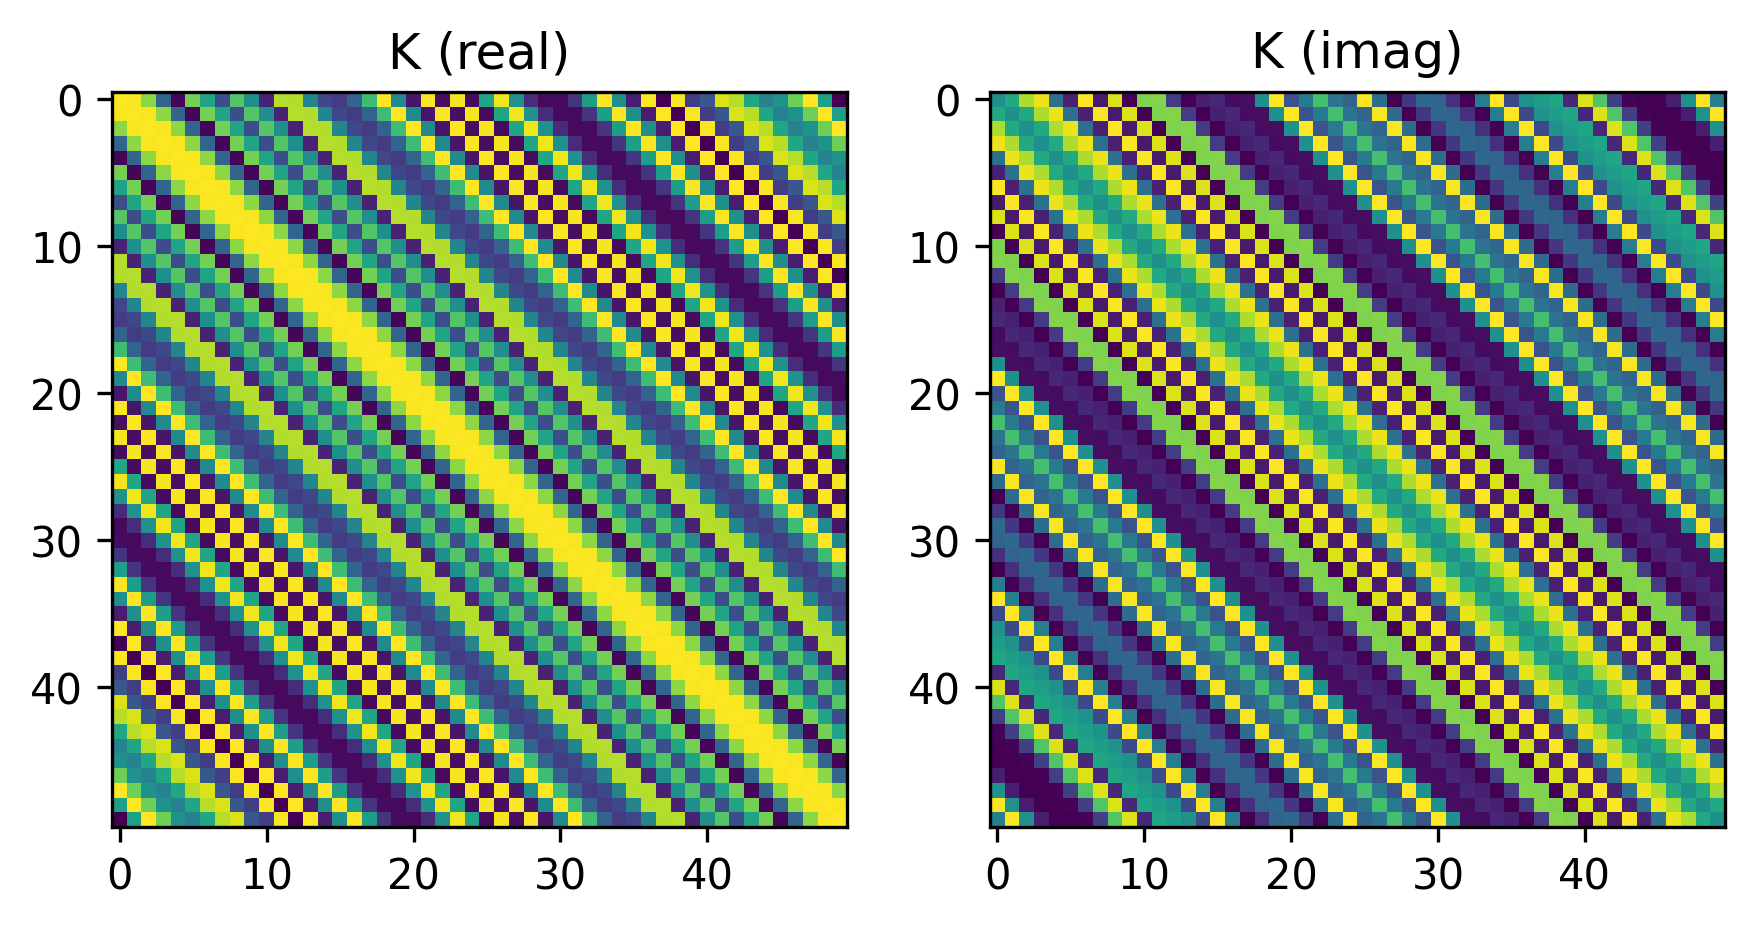

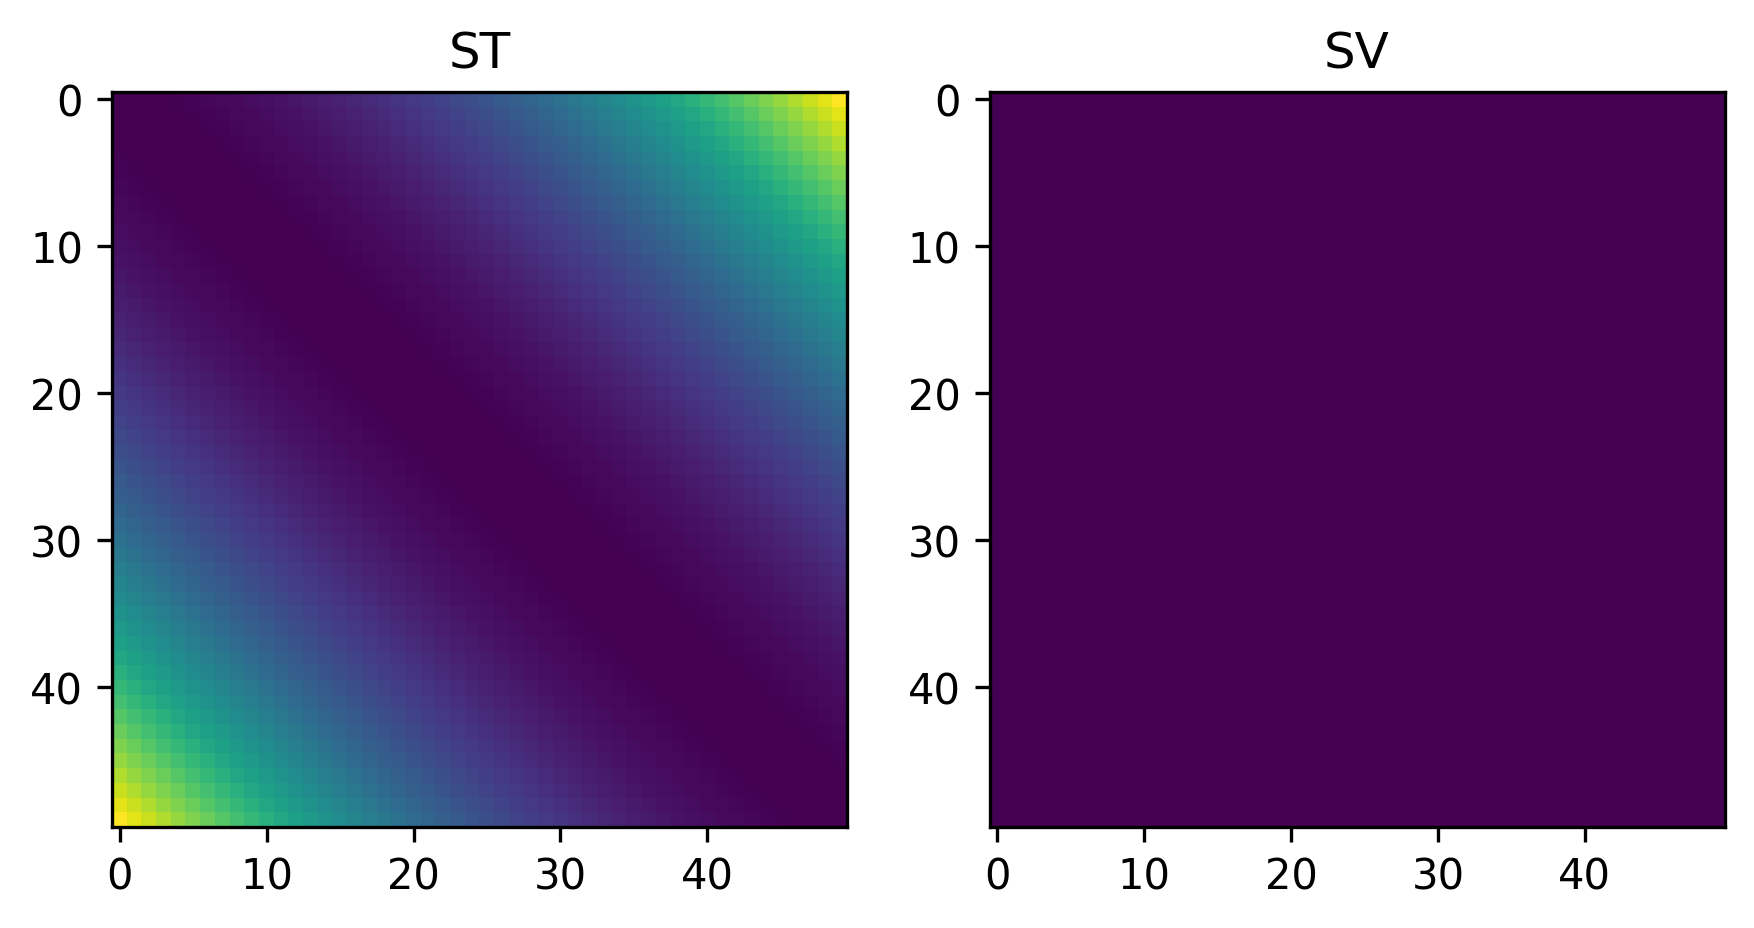

In [3]:
# run wavepacket simulations over a list of spatial scales
scales=[]
for item in scales:
    hprms=ObjectView(dict(scale=item, m=1, spatial_density=50,
                          time_density=50, xrange=8, trange=3,
                          momentum=15, vid_length=15, div=10))

    produce_graphs(hprms)

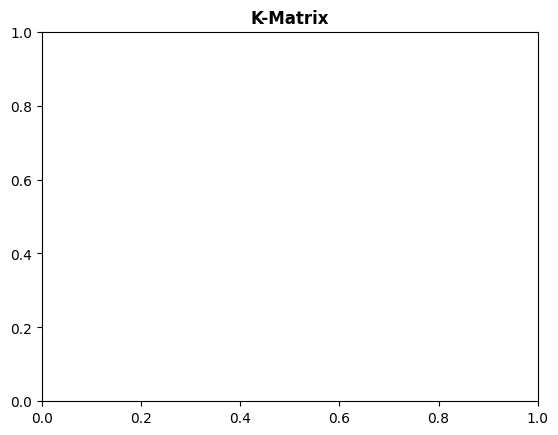

In [17]:
### This cell creates a video of K-matrices defined over a continuously deforming potential landscape ###

def make_Kvid(Ks, path, interval=60, **kwargs):
    plt.title('K-Matrix', fontweight="bold")
    fig = plt.figure(figsize=(6, 3), dpi=300)
    camera = Camera(fig)
    for i, K in enumerate(Ks):
      plt.imshow(K.real)
      camera.snap()
    anim = camera.animate(blit=True, interval=interval, **kwargs)
    anim.save(path) ; plt.close()

# defines the K's we wish to see in the video
def make_Ks(sweep):
    for i in range(sweep):
      # coeffs are polynomial coefficients of our potential energy function
      coeffs = [0, 0, i/2, i/6]
      if i == 0:
        Ks = init(hprms, coeffs).K[None, ...]
      else:
        Ks = np.concatenate((Ks, init(hprms, coeffs).K[None, ...]), axis=0)
    return Ks

path = 'sim.mp4'
sweep = 100; vid_length = 10
make_Kvid(make_Ks(sweep), path, 1000 * vid_length / sweep)

mp4 = open(path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=400 controls><source src="{}" type="video/mp4"></video>'.format(data_url))